# Isolationg the Stellar Rotation Period

To measure the rotation period of the star, we'll make a periodogram of the long cadence fluxes and see what periods stick out. 

#### Outline

* Mask out transits from long cadence light curve

* Use [`gatspy.periodic.LombScargle`](http://www.astroml.org/gatspy/periodic/API.html#gatspy.periodic.LombScargle) to make a periodogram for the flux and to fit for the dominant period

* Visualize!

### Loading, masking:

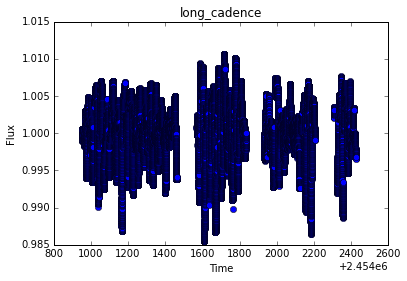

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from gatspy import periodic
import numpy as np
import warnings

import datacleaner
reload(datacleaner)
from datacleaner import LightCurve

# Load normalized long cadence light curve, mask out the transits 
long_cadence = LightCurve(name='long_cadence', 
                          **LightCurve.from_dir('../lightcurves/normalized_long').mask_in_transit())
long_cadence.plot()

### Get the periodogram, best period

In [3]:
#model = periodic.LombScargleFast(fit_period=True)
model = periodic.LombScargle(fit_period=True, Nterms=4)
model.optimizer.period_range = (20, 40)
model.fit(long_cadence.times.jd[::20], long_cadence.fluxes[::20], long_cadence.errors[::20]);

periods = np.linspace(model.optimizer.period_range[0],
                      model.optimizer.period_range[1], 
                      10000)
print("Best period: {0}".format(model.best_period))

header = 'HAT-P-11 rotation period (days)'
np.savetxt('../params/stellar_rotation_period.txt', [model.best_period], header=header)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)

Finding optimal frequency:
 - Estimated peak width = 0.00427
 - Using 5 steps per peak; omega_step = 0.000855
 - User-specified period range:  20 to 40
 - Computing periods at 185 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Best period: 29.9846024396


### Visualize

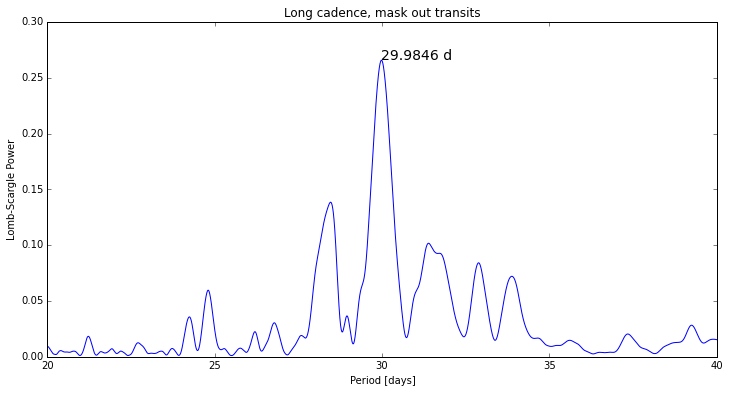

In [4]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(periods, scores)
ax.set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
max_ind = np.argmax(scores)
ax.text(periods[max_ind], scores[max_ind], 
        "{0:.4f} d".format(model.best_period),
        fontsize=14)
plt.show()

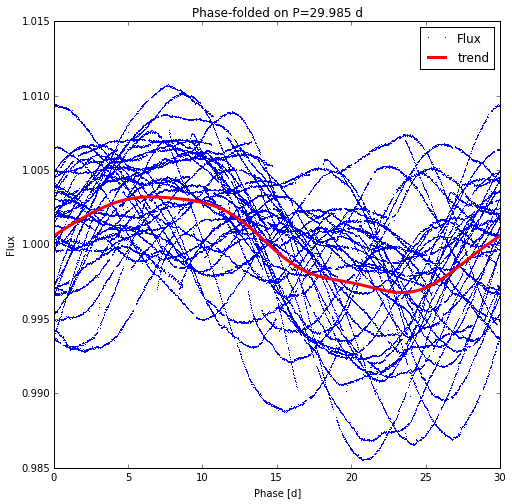

In [5]:
phase = long_cadence.times.jd % model.best_period
tfit = np.linspace(0, model.best_period, 100)
yfit = model.predict(tfit, period=model.best_period)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phase, long_cadence.fluxes, ',', label='Flux')
ax.plot(tfit, yfit, 'r', lw=3, label='trend')
ax.set(xlabel='Phase [d]', ylabel='Flux', title='Phase-folded on P={0:.3f} d'.format(model.best_period))
ax.legend()
plt.show()

### How different are the periods in each quarter?

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


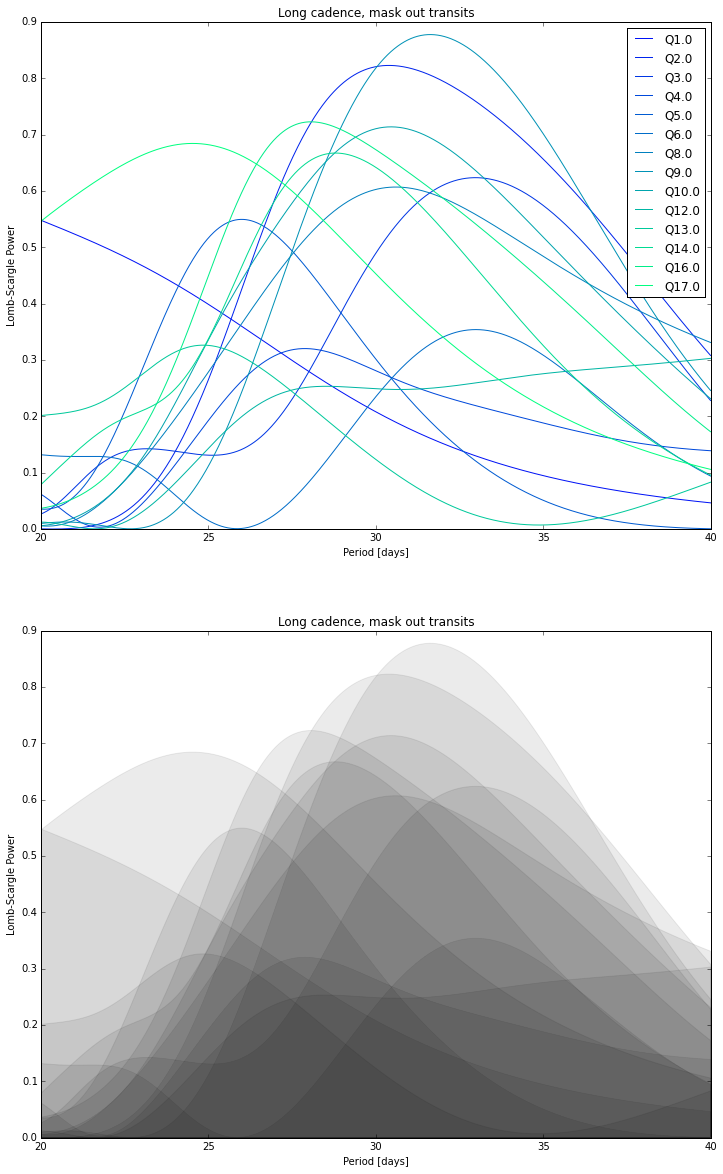

In [6]:
available_quarters = long_cadence.get_available_quarters()

# Ignore quarter zero!
available_quarters.pop(0)

best_periods = np.zeros(len(available_quarters))

fig, ax = plt.subplots(2, 1, figsize=(12, 20))

quarter_period_range = (20, 40)
quarter_periods = np.linspace(quarter_period_range[0],
                              quarter_period_range[1], 
                              1000)

my_cmap = lambda j: plt.cm.winter(float(j+1)/len(available_quarters))

for i, quarter in enumerate(available_quarters):
    lc = long_cadence.get_quarter(quarter)
    quarter_model = periodic.LombScargleFast(fit_period=True)#, Nterms=4)
    quarter_model.optimizer.period_range = quarter_period_range
    quarter_model.optimizer.quiet = True
    quarter_model.fit(lc.times.jd, lc.fluxes, lc.errors);

    best_periods[i] = quarter_model.best_period
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scores = quarter_model.score(quarter_periods)
        
    ax[0].plot(quarter_periods, scores, label='Q{0}'.format(quarter), 
            color=my_cmap(i))

    ax[1].fill_between(quarter_periods, 0, scores, color='k', alpha=0.08)
    
ax[0].set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
ax[0].legend()

ax[1].set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
plt.show()

Empirical error: 5.81043483116 d
Best period: 29.985 ± 5.8 d


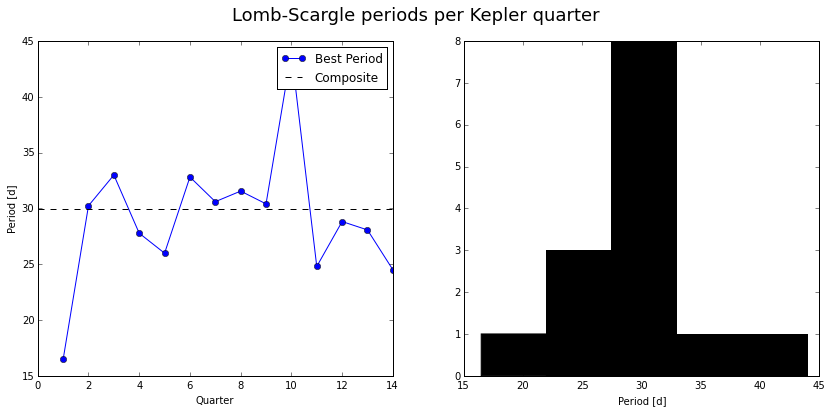

In [7]:
empirical_period_error = np.std(best_periods)
print('Empirical error: {0} d'.format(empirical_period_error))

print('Best period: {0:.3f} ± {1:.1f} d'.format(model.best_period, empirical_period_error))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(range(1, len(best_periods)+1), best_periods, 
           '-o', label='Best Period')
ax[0].axhline(model.best_period, label='Composite', color='k', ls='--')
ax[0].set(xlabel='Quarter', ylabel='Period [d]')
ax[0].legend()

ax[1].hist(best_periods, 5, facecolor='k')
ax[1].set(xlabel='Period [d]')

fig.suptitle('Lomb-Scargle periods per Kepler quarter', fontsize=18)
plt.show()

# How many long cadence points should we keep?

The long cadence data seem to sample the out-of-transit light curve at a higher frequency than we really need given the slow rotation of the star (see above, $P\sim 30$ d). Below we ask: at what periods is the star most active? Will periodograms at short periods reveal that we must sample at a high rate? 

In [8]:
model = periodic.LombScargle(fit_period=True, Nterms=4, optimizer_kwds={"quiet": True})
model.optimizer.period_range = (1, 10)
model.fit(long_cadence.times.jd, long_cadence.fluxes, long_cadence.errors);

periods = np.linspace(model.optimizer.period_range[0],
                      model.optimizer.period_range[1], 
                      10000)
print("Best period: {0}".format(model.best_period))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scores = model.score(periods)
# For example, silence optimizer output with `optimizer_kwds={"quiet": True}`.

Best period: 9.78506250077


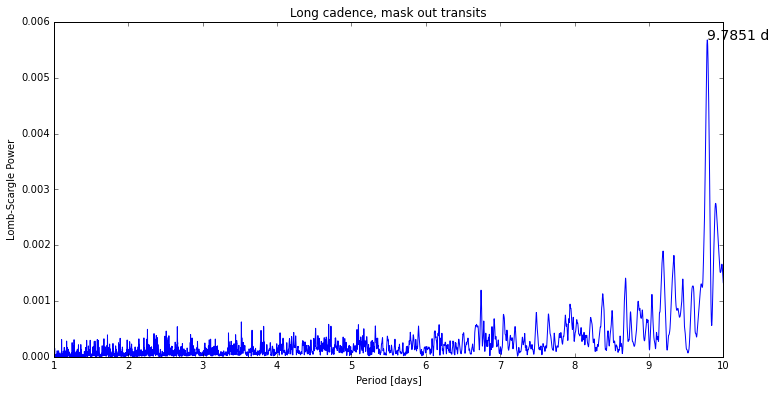

In [9]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(periods, scores)
ax.set(xlabel='Period [days]', ylabel='Lomb-Scargle Power', 
       title='Long cadence, mask out transits')
max_ind = np.argmax(scores)
ax.text(periods[max_ind], scores[max_ind], 
        "{0:.4f} d".format(model.best_period),
        fontsize=14)
plt.show()

## Would a periodic Gaussian process find a different period?

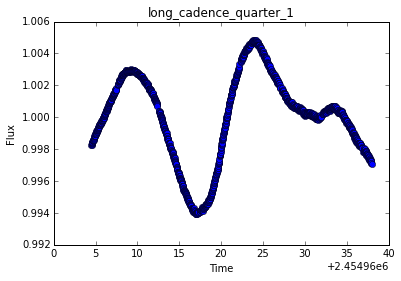

In [10]:
#for i, quarter in enumerate(available_quarters):
#    lc = long_cadence.get_quarter(quarter)
#    lc.plot()
q1 = long_cadence.get_quarter(1)
q1.plot()

$$k(x_i,x_j)=\sin(−\Gamma \sin^2{\frac{\pi}{P} ({x_i−x_j})} )$$

array([ 3.67818371,  4.59772964])

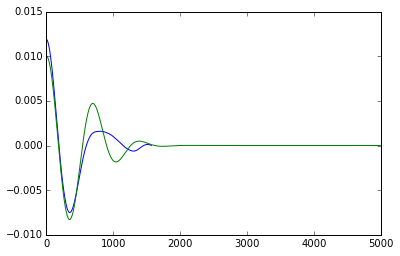

In [176]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

def lin(x):
    return np.linspace(0, len(x), 5000)

def expsin2(x, gamma, P):
    return np.sin(-gamma*np.sin(np.pi*lin(x)/P)**2)

def expsqcos(x, tau, P):
    return np.exp(-0.5*(lin(x)/tau)**2) * np.cos(2*np.pi*lin(x)/P)

plt.plot(autocorr(q1.fluxes - 1))
plt.plot(0.01*expsqcos(q1.fluxes, 180, 225));

np.array([180, 225])*np.median(np.diff(q1.times.jd))

In [199]:
4.59772964*6

27.586377839999997

In [177]:
import george
from george import kernels
import emcee
from scipy import optimize


def lnprior(theta):
    tau, period = theta
    #period, ln_white = theta
    #if np.log(20) < period < np.log(40):
    if (0.01 < period < 100) and (0 < tau < 300):# and (-20 < ln_white < -5):
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    #gamma, period, ln_white = theta
    tau, period = theta
    kernel = kernels.CosineKernel(period=period) * kernels.ExpSquaredKernel(metric=tau)
    gp = george.GP(kernel, solver=george.BasicSolver)
    #print(q1.times.jd[0], ln_white, q1.errors[0], np.sqrt(np.exp(ln_white)**2 + q1.errors**2)[0])
    gp.compute(x, yerr)#np.sqrt(np.exp(ln_white)**2 + q1.errors**2))

    #return -0.5*(np.sum((y-model)**2/yerr**2))
    return gp.lnlikelihood(y - 1)
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

theta = [3.67818371,  29.9]#, -7]
#theta = [29.9/2, -7]
lc = q1

#ndim, nwalkers = 3, 6
ndim, nwalkers = 2, 4
pos = [np.array(theta) + 1*np.random.randn(ndim) 
       for i in range(nwalkers)]

assert all([lnprior(p) == 0 for p in pos])

In [169]:
lnlike(theta, lc.times.jd, lc.fluxes, lc.errors)

3359.9315494819039

[  2.88006773  29.90994548]
[  4.84095929  30.82945469]
[  2.7369893   28.45791826]
[  2.85454124  31.38229577]


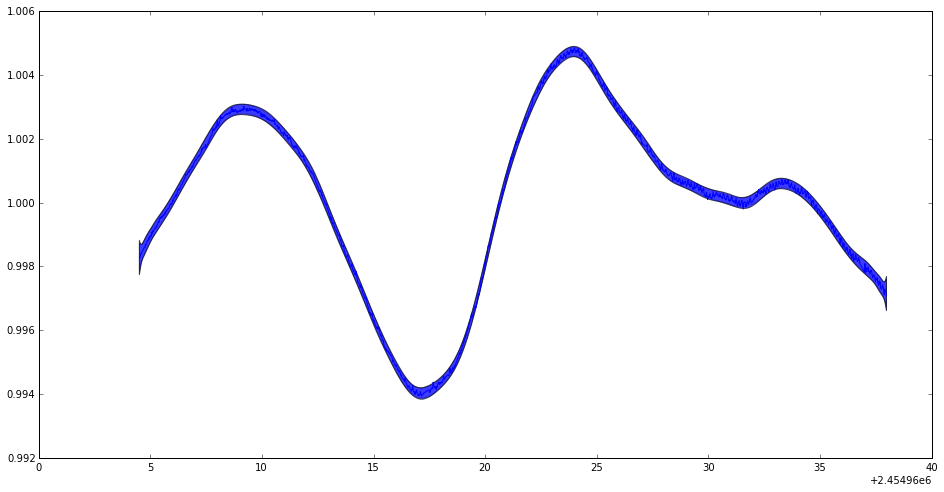

In [180]:
plt.figure(figsize=(16,8))
plt.plot(lc.times.jd, lc.fluxes)

for position in pos:
    print(position)
    #period, ln_white = position
    #gamma, period, ln_white = position
    tau, period = position
    #kernel = kernels.CosineKernel(period=period)
    kernel = kernels.CosineKernel(period=period) * kernels.ExpSquaredKernel(metric=tau)
    gp = george.GP(kernel, solver=george.BasicSolver)
    gp.compute(lc.times.jd, lc.errors + 0.001)#np.sqrt(np.exp(ln_white)**2 + lc.errors**2))

    mu, cov = gp.predict(lc.fluxes - 1, lc.times.jd)
    std = np.sqrt(np.diag(cov))

#print(mu-std, mu+std)
    plt.fill_between(lc.times.jd, 1+ mu-std, 1+ mu+std, alpha=0.3)
plt.show()

In [181]:

pool = emcee.interruptible_pool.InterruptiblePool(processes=4)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, pool=pool,
                                args=(lc.times.jd, lc.fluxes, lc.errors))
sampler.run_mcmc(pos, 100);
# chi2 = lambda *args: -2 * lnlike(*args)
# result = optimize.minimize(chi2, theta, args=(lc.times.jd, lc.fluxes, lc.errors))
# print(result)

(array([[  1.90162212e-02,   1.22721873e+01],
        [  1.52478213e-01,   1.65318671e+01],
        [  1.77819683e-02,   1.27196627e+01],
        [  1.57269767e-01,   1.88528394e+01]]),
 array([ 7953.92452839,  4889.54737317,  8018.26581978,  4888.36793076]),
 ('MT19937', array([ 814688461, 1837236331, 1452381323, 2163694116, 1928047941,
         3911028365,  264444366, 1525134275, 1427291354, 2845968209,
         3448268596, 2021022043, 1696019354, 2152761201, 1149389769,
         2751140442,  342856118,  340055569, 2929666567, 3621080965,
           89238651,  329420564, 2901916696, 2537633344,  672481407,
          219582397, 2604629103, 1476189642, 1039757542, 3615753211,
          618185187, 3074785858, 3783741009, 2653951071, 2360990841,
         3226720675, 1027925183, 4030521224, 2299635212, 1869596546,
         2344331868, 3361002110, 4256112105, 3171738289, 3400910392,
         1805842061, 2439606405, 3059322966,  309017311, 3958499173,
         1336216520, 3390891559, 207088

In [209]:
sampler.run_mcmc(pos, 10000);

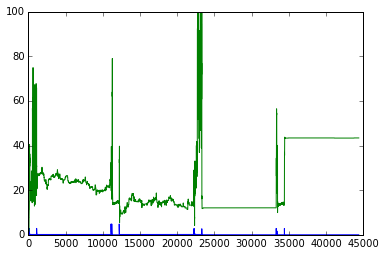

In [210]:
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
#sampler.flatchain

plt.plot(sampler.flatchain)
plt.show()

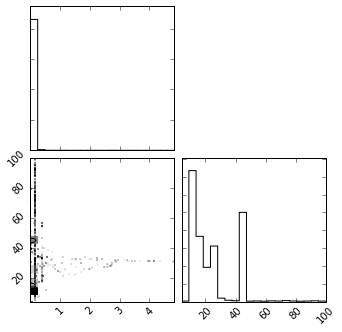

In [211]:
from corner import corner

corner(sampler.flatchain[1000:, :]);

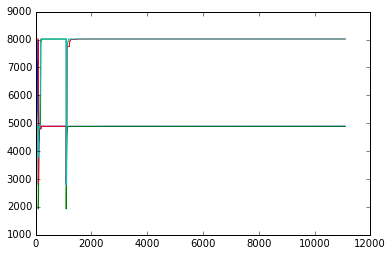

In [213]:
plt.plot(sampler.lnprobability.T)